In [117]:
packages <- c('caret',
              'xgboost',
              'ggplot2',
              'ggfortify',
              'glmnet',
              'tidyr',
              'dplyr',
              'gplots',
              'RColorBrewer',
              'JGL',
              'huge',
              'msgl',
              'missForest')

# load package is it extis, if not, install it and then load it
for (package in packages) {
    if (!require(package, character.only=TRUE, quietly=TRUE)) {
        install.packages(package, repos='http://cran.us.r-project.org')
        require(package, character.only=TRUE, quietly=TRUE)
    }
}

In [3]:
(.packages())

[1] "missForest"   "itertools"    "iterators"    "randomForest" "msgl"        
 [6] "sglOptim"     "huge"         "MASS"         "JGL"          "igraph"      
[11] "RColorBrewer" "gplots"       "dplyr"        "tidyr"        "glmnet"      
[16] "foreach"      "Matrix"       "xgboost"      "caret"        "ggplot2"     
[21] "lattice"      "stats"        "graphics"     "grDevices"    "utils"       
[26] "datasets"     "methods"      "base"

In [6]:
data_dir <- "~/shared_data/hd_mouse_allelic_series"
data_files_to_load <- list.files(path=data_dir)

In [7]:
for (data_file in data_files_to_load) {
    full_data_path <- file.path(data_dir,data_file)
    print(full_data_path)
    load(full_data_path)
}

[1] "~/shared_data/hd_mouse_allelic_series/all_mrna_data_NPN.Rdata"
[1] "~/shared_data/hd_mouse_allelic_series/all_mrna_data_RAW.Rdata"
[1] "~/shared_data/hd_mouse_allelic_series/all_mrna_data_tidy_NPN.Rdata"
[1] "~/shared_data/hd_mouse_allelic_series/all_mrna_data_tidy_RAW.Rdata"


In [8]:
ls()

[1] "all_mrna_data_npn"      "all_mrna_data_npn_tidy" "all_mrna_data_raw"     
 [4] "all_mrna_data_raw_tidy" "data_dir"               "data_file"             
 [7] "data_files_to_load"     "full_data_path"         "package"               
[10] "packages"               "q"                      "quit"

In [11]:
wt_mice_inds <- (all_mrna_data_npn$GenoType == 'WT')
all_mrna_data_npn[wt_mice_inds,c('Genotyped.CAG')] <- 7
all_mrna_data_npn[wt_mice_inds,c('Numeric.Q')] <- 7
sum(is.na(all_mrna_data_npn))

[1] 0

In [12]:
table(all_mrna_data_npn$Numeric.Q)


  7  20  80  92 111 140 175 
112  72  71  72  72  72  72 

In [13]:
head(all_mrna_data_npn[,1:15])

,PGI.Mouse.ID,observationid,Tissue,Seq.Type,GenoType,Housing.Conditions,Numeric.Q,Sex,Genotyped.CAG,Month,Sample.ID,0610005C13Rik,0610007N19Rik,0610007P14Rik,0610008F07Rik
645,Q20B0009.08,X300195_Q20B0009_08_L1.D707,liver,mRNA,HET (Q20),Housed with Q20 and WT animals,20,MALE,19.9738,10,X300195_Q20B0009_08_L1.D707,0.8314238323527,-2.4469175947943,0,1.39185350876437
384,Q20B0013.05,X300196_Q20B0013_05_L1.D708,liver,mRNA,WT,Housed with Q20 and WT animals,7,FEMALE,7,10,X300196_Q20B0013_05_L1.D708,1.04695072634965,-0.377734864681174,0.694543879329425,1.98835370732709
656,Q20B0009.03,X300197_Q20B0009_03_L1.D709,liver,mRNA,WT,Housed with Q20 and WT animals,7,MALE,7,10,X300197_Q20B0009_03_L1.D709,0.818383542227749,-2.4469175947943,0.208430069625774,1.31809486564066
657,Q92B0005.05,X300198_Q92B0005_05_L1.D710,liver,mRNA,HET (Q92),Housed with Q92 and WT animals,92,FEMALE,102.467,10,X300198_Q92B0005_05_L1.D710,1.13871370377917,0.091858546935898,0.682731914546304,1.26571831259776
658,Q140B0001.08,X300199_Q140B0001_08_L1.D711,liver,mRNA,HET (Q140),Housed with Q140 and WT animals,140,MALE,148.267,10,X300199_Q140B0001_08_L1.D711,1.12135361499196,-0.0871360863922832,0.454425299207515,1.03902356084791
659,Q92B0006.05,X300200_Q92B0006_05_L29,liver,mRNA,HET (Q92),Housed with Q92 and WT animals,92,FEMALE,101.695,10,X300200_Q92B0006_05_L29,0.596842270823333,-0.786350866409705,0.477921179201813,0.673932615336486


In [163]:
data_subset_cortex_6 <- filter(all_mrna_data_npn, 
                    Tissue == "cortex",
                    Month == 6
                    )
dim(data_subset_cortex_6)

data_subset_striatum_6 <- filter(all_mrna_data_npn, 
                    Tissue == "striatum",
                    Month == 6
                    )
dim(data_subset_striatum_6)

data_subset_cortex_10 <- filter(all_mrna_data_npn, 
                    Tissue == "cortex",
                    Month == 10
                    )
dim(data_subset_cortex_10)

data_subset_striatum_10 <- filter(all_mrna_data_npn, 
                    Tissue == "striatum",
                    Month == 10
                    )
dim(data_subset_striatum_10)

[1]    56 23362

[1]    96 23362

[1]    56 23362

[1]    56 23362

In [165]:
table(data_subset_striatum_10$Numeric.Q)


  7  20  80  92 111 140 175 
  8   8   8   8   8   8   8 

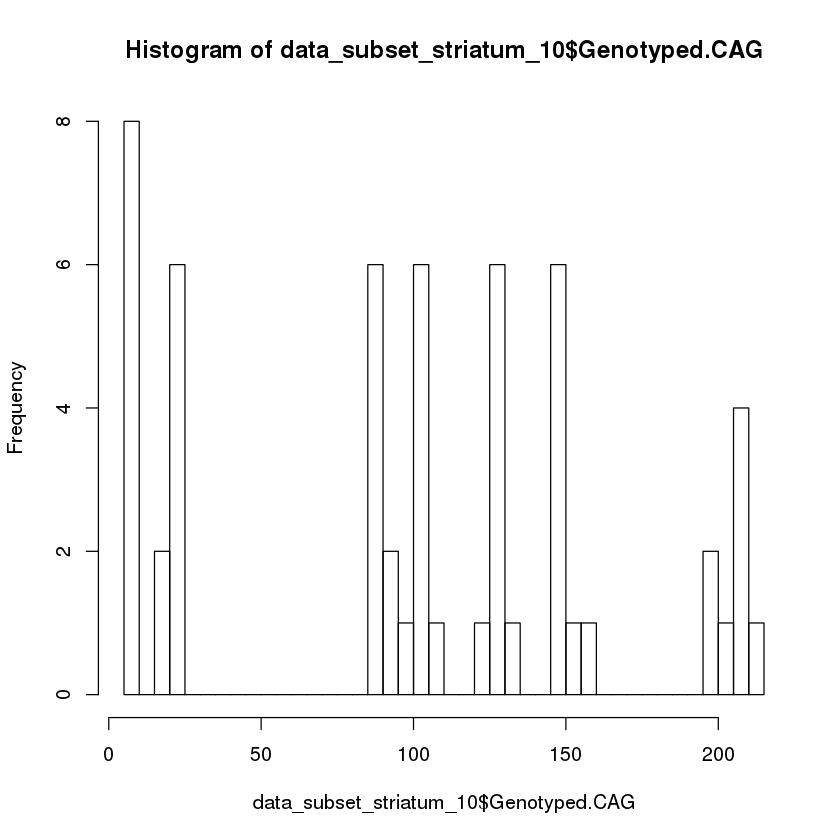

In [167]:
hist(data_subset_striatum_10$Genotyped.CAG, breaks=50)

In [168]:
y <- data_subset_striatum_10$Genotyped.CAG
y_q <- data_subset_striatum_10$Numeric.Q
X <- as.matrix(data_subset_striatum_10[-c(1:11)])
length(y)
dim(X)

[1] 56

[1]    56 23351

In [169]:
test_train_inds <- createDataPartition(y, p=0.75, groups=length(table(y_q)))
# hist(y[-test_train_inds$Resample1],breaks=50)

X_test_train <- X[test_train_inds$Resample1,]
y_test_train <- y[test_train_inds$Resample1]
X_holdout <- X[-test_train_inds$Resample1,]
y_holdout <- y[-test_train_inds$Resample1]

In [170]:
alpha_values <- seq(0,1,0.1)

cv_info <- data.frame()

for (alpha_value in alpha_values){
    fit.cv <- cv.glmnet(X_test_train, y_test_train, 
                        alpha = alpha_value, family='gaussian', type.measure = "deviance"
                       )
        
    best_lambda_index_lse <- match(fit.cv$lambda.1se, fit.cv$lambda)
    best_lambda_index_min <- match(fit.cv$lambda.min, fit.cv$lambda)
    cv_info <- rbind(cv_info, data.frame(
                                            alpha=alpha_value,
                                            lowest_lse=fit.cv$cvm[best_lambda_index_lse],
                                            nonzero_params_lse=fit.cv$nzero[best_lambda_index_lse],
                                            lowest_mse=fit.cv$cvm[best_lambda_index_min],
                                            nonzero_params_mse=fit.cv$nzero[best_lambda_index_min]
                                        )
                    )
}

In [171]:
cv_info

,alpha,lowest_lse,nonzero_params_lse,lowest_mse,nonzero_params_mse
s27,0.000,1326.915,20821.000,1099.937,20821.000
s42,0.1000,928.7146,136.0000,801.8160,189.0000
s40,0.2000,938.9237,77.0000,749.8313,113.0000
s41,0.3000,875.4479,51.0000,710.0726,89.0000
s36,0.4000,1032.4553,41.0000,808.7048,62.0000
s47,0.5000,799.3635,36.0000,665.3138,64.0000
s46,0.6000,939.9067,31.0000,777.5949,59.0000
s31,0.7000,1107.8458,20.0000,887.0016,56.0000
s38,0.8000,1012.2931,19.0000,784.3855,58.0000
s48,0.9000,1009.9792,24.0000,809.2952,52.0000


In [172]:
fit.cv <- cv.glmnet(X_test_train, y_test_train, 
                        alpha = 0.5, family='gaussian', type.measure = "deviance"
                       )

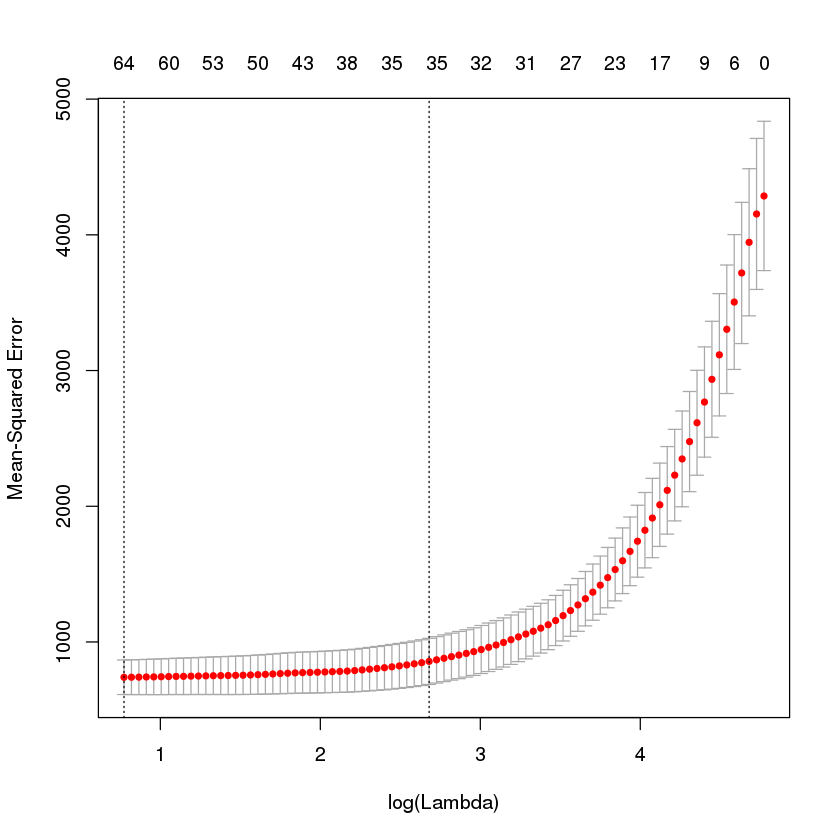

In [173]:
plot(fit.cv)

In [174]:
fit = glmnet(X_test_train, y_test_train, alpha = 0.5, family = 'gaussian')

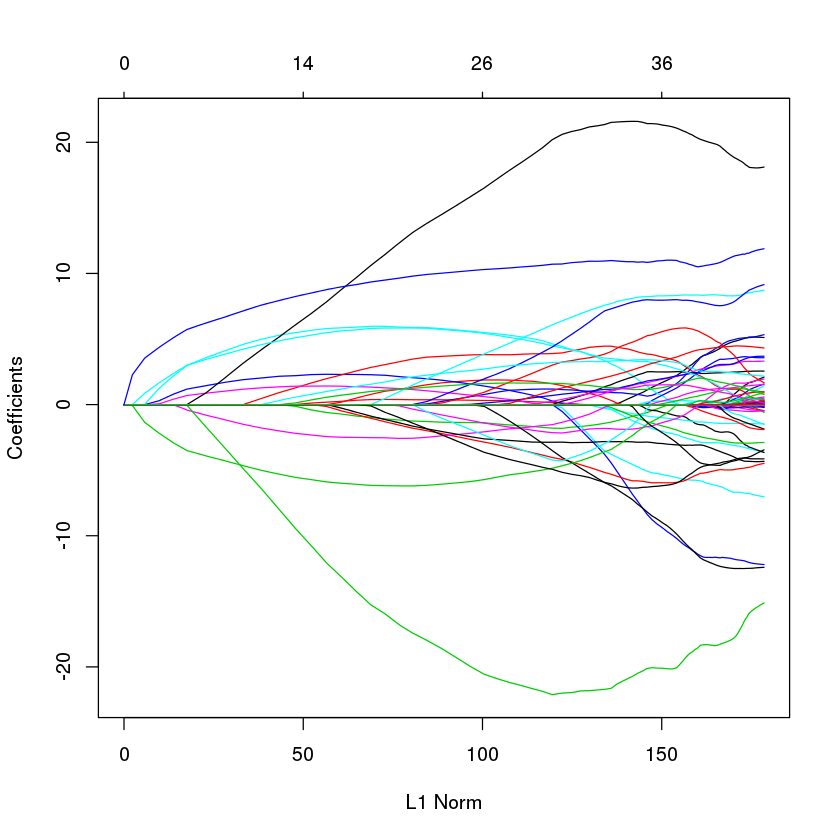

In [175]:
plot(fit)

In [176]:
best_lambda_index <- match(fit.cv$lambda.1se, fit.cv$lambda)
preds <- predict(fit, X_holdout)
y_pred <- preds[,best_lambda_index]

In [178]:
df_pred_perf <- data.frame(
    predicted.CAGlength=y_pred,
    actual.CAGlength=y_holdout,
    Numeric.Q=as.factor(data_subset_striatum_10$Numeric.Q[-test_train_inds$Resample1])
)
# str(df_pred_perf)

Warning message:
In cor.test.default(df_pred_perf$predicted.CAGlength, df_pred_perf$actual.CAGlength, : Cannot compute exact p-value with ties


	Kendall's rank correlation tau

data:  df_pred_perf$predicted.CAGlength and df_pred_perf$actual.CAGlength
z = 3.6429, p-value = 0.0002696
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.8091839 


Warning message:
In cor.test.default(df_pred_perf$predicted.CAGlength, df_pred_perf$actual.CAGlength, : Cannot compute exact p-value with ties


	Spearman's rank correlation rho

data:  df_pred_perf$predicted.CAGlength and df_pred_perf$actual.CAGlength
S = 18.532, p-value = 8.064e-06
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.9352028 


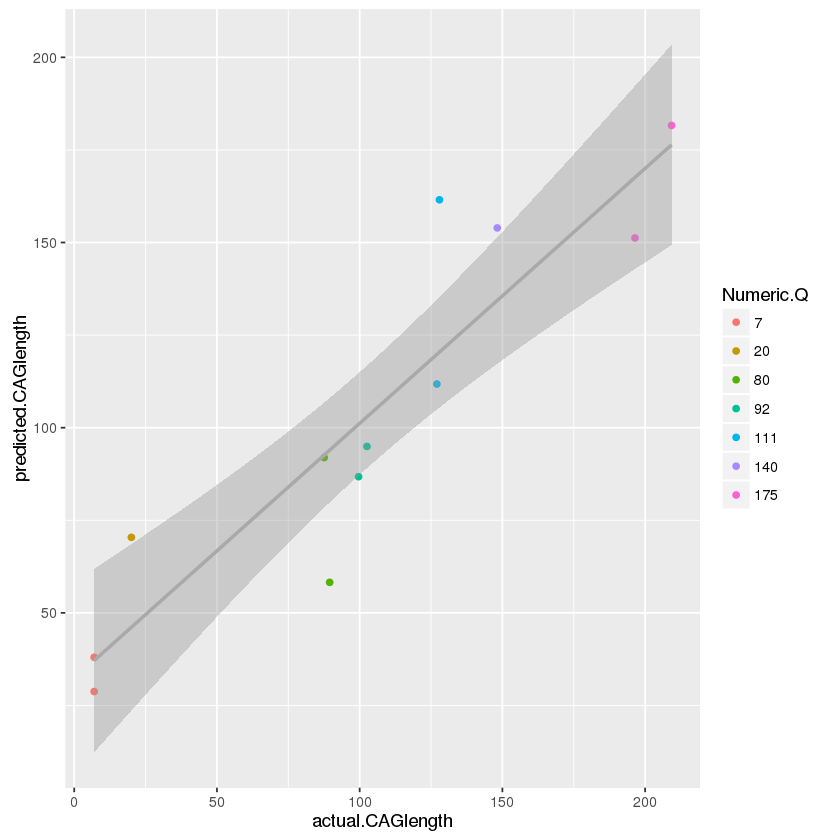

In [179]:
p <- ggplot(data=df_pred_perf, aes(x=actual.CAGlength, y=predicted.CAGlength)) + 
geom_point(aes(colour=Numeric.Q)) +
stat_smooth(method = "lm",colour="darkgrey")

p

cor.test(df_pred_perf$predicted.CAGlength, df_pred_perf$actual.CAGlength, method="kendall") 
cor.test(df_pred_perf$predicted.CAGlength, df_pred_perf$actual.CAGlength, method="spearman") 

In [180]:
best_lambda_index <- match(fit.cv$lambda.1se, fit.cv$lambda)
preds_overfit <- predict(fit, X)
y_pred_overfit <- preds_overfit[,best_lambda_index]

df_overfit <- data.frame(
    predicted.CAGlength=y_pred_overfit,
    actual.CAGlength=y,
    Numeric.Q=as.factor(data_subset_striatum_10$Numeric.Q)
)
# str(df_overfit)


	Kendall's rank correlation tau

data:  df_overfit$predicted.CAGlength and df_overfit$actual.CAGlength
z = 9.444, p-value < 2.2e-16
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.8747964 


Warning message:
In cor.test.default(df_overfit$predicted.CAGlength, df_overfit$actual.CAGlength, : Cannot compute exact p-value with ties


	Spearman's rank correlation rho

data:  df_overfit$predicted.CAGlength and df_overfit$actual.CAGlength
S = 745.06, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.9745364 


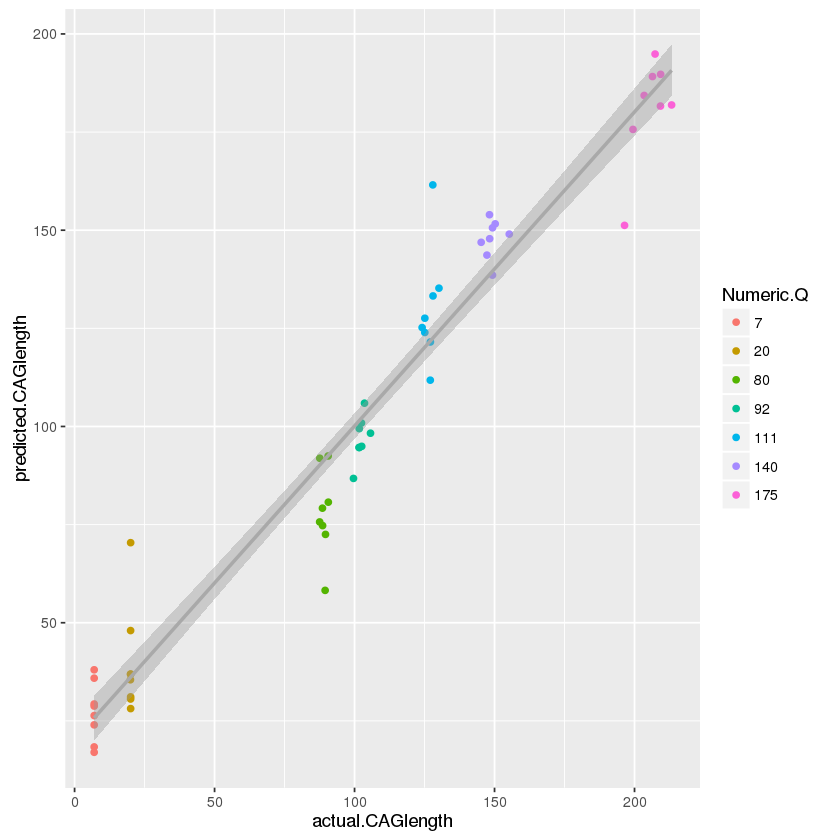

In [181]:
p_overfit <- ggplot(data=df_overfit, aes(x=actual.CAGlength, y=predicted.CAGlength)) + 
geom_point(aes(colour=Numeric.Q)) +
stat_smooth(method = "lm", formula = y ~ x, colour="darkgrey")

p_overfit

cor.test(df_overfit$predicted.CAGlength, df_overfit$actual.CAGlength, method="kendall")
cor.test(df_overfit$predicted.CAGlength, df_overfit$actual.CAGlength, method="spearman")

In [182]:
best_betas <- fit$beta[,best_lambda_index]
degs <- best_betas[best_betas != 0.0]

In [183]:
deg_df <- cbind(Numeric.Q=y_q,data.frame(X[,names(degs)]))
deg_df_tidy <- gather(deg_df, 'Gene', 'Expression', -Numeric.Q)

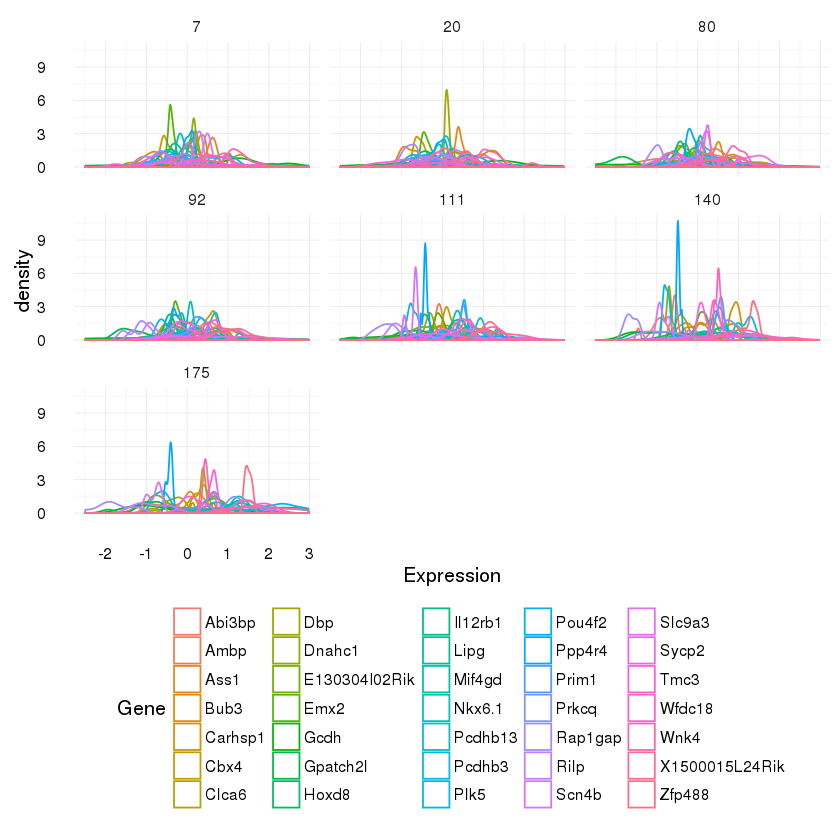

In [184]:
p_deg <- ggplot(deg_df_tidy) + 
    geom_density(aes(Expression, colour = Gene)) +
    theme_minimal() + 
    theme(legend.position = "bottom")

p_deg + facet_wrap(~ Numeric.Q)

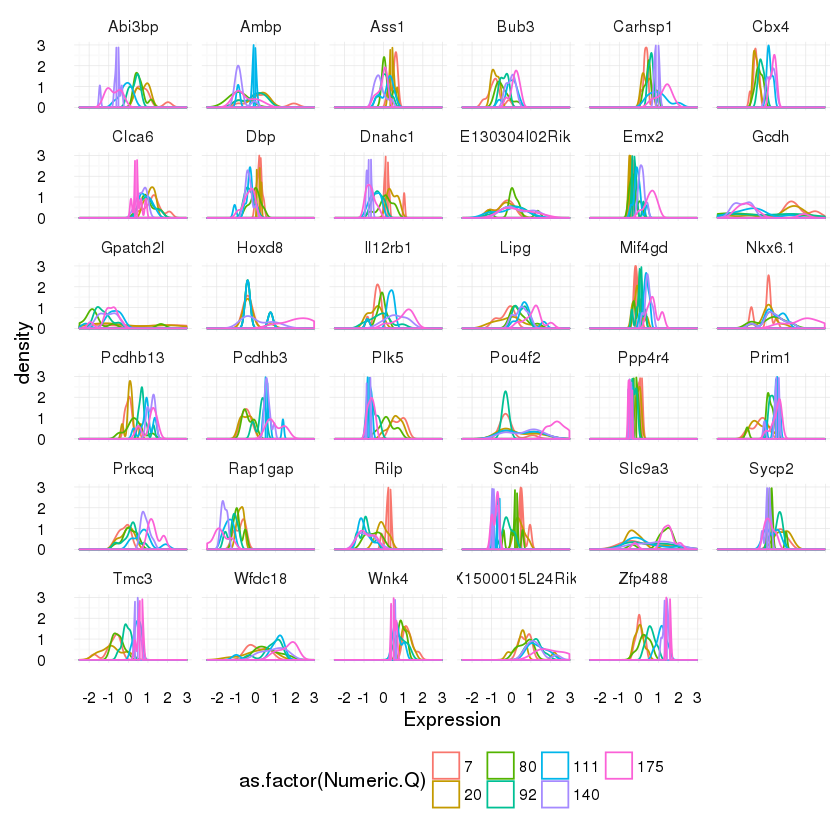

In [187]:
p_deg <- ggplot(deg_df_tidy) + 
    geom_density(aes(Expression, colour = as.factor(Numeric.Q))) +
    theme_minimal() + 
    theme(legend.position = "bottom")

p_deg + facet_wrap(~ Gene) + ylim(0,3)

In [149]:
foo <- data(example.data)

In [153]:
fgl.results = JGL(Y=example.data,penalty="fused",lambda1=.25,lambda2=.1)

In [154]:
str(fgl.results)

List of 3
 $ theta            :List of 2
  ..$ : num [1:47, 1:47] 1.04 0 0 0 0 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:47] "gene 5" "gene 7" "gene 9" "gene 15" ...
  .. .. ..$ : chr [1:47] "gene 5" "gene 7" "gene 9" "gene 15" ...
  ..$ : num [1:47, 1:47] 1.04 0 0 0 0 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:47] "gene 5" "gene 7" "gene 9" "gene 15" ...
  .. .. ..$ : chr [1:47] "gene 5" "gene 7" "gene 9" "gene 15" ...
 $ theta.unconnected:List of 2
  ..$ : Named num [1:153] 1.243 0.909 0.976 1.069 1.009 ...
  .. ..- attr(*, "names")= chr [1:153] "gene 1" "gene 2" "gene 3" "gene 4" ...
  ..$ : Named num [1:153] 1.243 0.909 0.976 1.289 1.009 ...
  .. ..- attr(*, "names")= chr [1:153] "gene 1" "gene 2" "gene 3" "gene 4" ...
 $ connected        : logi [1:200] FALSE FALSE FALSE FALSE TRUE FALSE ...
 - attr(*, "class")= chr "jgl"


In [155]:
print.jgl(fgl.results)


Number of connected nodes:  47 
Number of subnetworks in each class:  15 11 
Number of edges in each class:  17 14 
Number of edges shared by all classes:  4 
L1 norm of off-diagonal elements of classes' Thetas:  0.8156875 0.6878476 


In [156]:
ggl.results = JGL(Y=example.data,penalty="group",lambda1=.15,lambda2=.2,return.whole.theta=TRUE)

In [157]:
str(ggl.results)

List of 2
 $ theta    :List of 2
  ..$ : num [1:200, 1:200] 1.28 0 0 0 0 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:200] "gene 1" "gene 2" "gene 3" "gene 4" ...
  .. .. ..$ : chr [1:200] "gene 1" "gene 2" "gene 3" "gene 4" ...
  ..$ : num [1:200, 1:200] 1.21 0 0 0 0 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:200] "gene 1" "gene 2" "gene 3" "gene 4" ...
  .. .. ..$ : chr [1:200] "gene 1" "gene 2" "gene 3" "gene 4" ...
 $ connected: logi [1:200] FALSE FALSE FALSE FALSE FALSE FALSE ...
 - attr(*, "class")= chr "jgl"


In [158]:
print.jgl(ggl.results)


Number of connected nodes:  47 
Number of subnetworks in each class:  16 11 
Number of edges in each class:  19 15 
Number of edges shared by all classes:  7 
L1 norm of off-diagonal elements of classes' Thetas:  0.617223 0.4538536 


In [159]:
str(example.data)

List of 2
 $ : num [1:100, 1:200] 0.395 -2.03 -1.704 -0.469 1.75 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:200] "gene 1" "gene 2" "gene 3" "gene 4" ...
 $ : num [1:100, 1:200] -1.548 1.45 -0.812 -0.589 0.69 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:200] "gene 1" "gene 2" "gene 3" "gene 4" ...


In [162]:
dim(example.data[[1]])

[1] 100 200